# Package

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,get_scorer_names
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import utils

# Load Data

In [3]:
# Read the input file into a pandas DataFrame
df = pd.read_excel('20241220_forcasting_attendance.xlsx')

df =utils.process_data(df)
print(df[['gallery','gallery_type_encoded']].drop_duplicates())
print(df[['era','era_encoded']].drop_duplicates())

    gallery  gallery_type_encoded
0      Main                     1
5   Sackler                     2
10      GJW                     0
           era  era_encoded
0    Pre-covid            2
23       Covid            0
33  Post-covid            1


# Log Transform

In [4]:
df_model = utils.build_model_df(df)

df_model = utils.log_transform(df_model)

/Users/xiaoxiao.zeng/Library/CloudStorage/OneDrive-RoyalAcademyofArts/analysis_env/project/Predicting Model/Github repo/20241220 Final Model/utils.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,new_col] = np.log1p(df[i])
/Users/xiaoxiao.zeng/Library/CloudStorage/OneDrive-RoyalAcademyofArts/analysis_env/project/Predicting Model/Github repo/20241220 Final Model/utils.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,new_col] = np.log1p(df[i])
/Users/xiaoxiao.zeng/Library/CloudStorag

# Log - Log model

In [5]:
print("5th percentile of log_avg_month_search:",np.percentile(df_model['log_avg_month_search'], 5))
print("95th percentile of log_avg_month_search:",np.percentile(df_model['log_avg_month_search'], 95))

print("5th percentile of log_days:",np.percentile(df_model['log_num_days'], 5))
print("95th percentile of log_days:",np.percentile(df_model['log_num_days'], 95))

print("5th percentile of log_days:",np.percentile(df_model['log_reach'], 5))
print("95th percentile of log_days:",np.percentile(df_model['log_reach'], 95))


5th percentile of log_avg_month_search: 6.767087363102873
95th percentile of log_avg_month_search: 10.111281130661236
5th percentile of log_days: 4.095171027319661
95th percentile of log_days: 4.661023165248526
5th percentile of log_days: 15.781607248793195
95th percentile of log_days: 19.02665929859185


In [6]:
# Manual Winsorization
df_model = utils.winsorization(df_model)

/Users/xiaoxiao.zeng/Library/CloudStorage/OneDrive-RoyalAcademyofArts/analysis_env/project/Predicting Model/Github repo/20241220 Final Model/utils.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[temp] = df[i].clip(lower=low, upper=high)
/Users/xiaoxiao.zeng/Library/CloudStorage/OneDrive-RoyalAcademyofArts/analysis_env/project/Predicting Model/Github repo/20241220 Final Model/utils.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[temp] = df[i].clip(lower=low, upper=high)
/Users/xiaoxiao.zeng/L

In [7]:
thresholds_main = np.percentile(df_model[df_model['gallery_type_encoded'] ==1]['log_reach_ex_outlier'], range(50, 100, 1))
thresholds_small= np.percentile(df_model[df_model['gallery_type_encoded'] !=1]['log_reach_ex_outlier'], range(50, 100, 1))
best_threshold = None
best_aic = np.inf

for threshold_small in thresholds_small: 
    for threshold_main in thresholds_main:
        df_model.loc[:,'high_search_main'] = 0
        df_model.loc[np.logical_and(df_model['gallery_type_encoded'] ==1, df_model.log_reach > threshold_main),'high_search_main'] = 1
        df_model.loc[:,'high_search_small'] = 0
        df_model.loc[np.logical_and(df_model['gallery_type_encoded'] !=1, df_model.log_reach > threshold_small),'high_search_small'] = 1
        
        df_model.loc[:,'high_search_small'] = df_model.high_search_small.astype(int)
        df_model.loc[:,'high_search_main'] = df_model.high_search_main.astype(int)

        model = smf.ols('log_total_attendance ~ log_avg_month_search_ex_outlier  +log_num_days_ex_outlier + C(gallery_type_encoded)* C(era_encoded) +C(high_search_main) +C(high_search_small)  \
                        ', data=df_model).fit()
            
        if model.aic < best_aic:
            best_aic = model.aic
            best_threshold_small = threshold_small
            best_threshold_main = threshold_main

print(f"Best threshold: {best_threshold_small,best_threshold_main},  Best AIC: {best_aic}")

/var/folders/4v/ysh46ndx0zl5cffpg7yz9xwh0000gp/T/ipykernel_3633/1699805091.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,'high_search_main'] = 0
/var/folders/4v/ysh46ndx0zl5cffpg7yz9xwh0000gp/T/ipykernel_3633/1699805091.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,'high_search_small'] = 0


Best threshold: (np.float64(18.341724668657182), np.float64(18.61943327969241)),  Best AIC: -7.370848095924742


In [10]:
df_model.loc[:,'high_search_main'] = 0
df_model.loc[np.logical_and(df_model['gallery_type_encoded'] ==1, df_model.log_reach > best_threshold_main),'high_search_main'] = 1
df_model.loc[:,'high_search_small'] = 0
df_model.loc[np.logical_and(df_model['gallery_type_encoded'] !=1, df_model.log_reach > best_threshold_small),'high_search_small'] = 1

df_model.loc[:,'high_search_small'] = df_model.high_search_small.astype(int)
df_model.loc[:,'high_search_main'] = df_model.high_search_main.astype(int)

model = smf.ols('log_total_attendance ~ log_avg_month_search_ex_outlier +log_num_days_ex_outlier  + C(era_encoded)*C(gallery_type_encoded) +C(high_search_main) +C(high_search_small)', data=df_model).fit()

predicted_log_attendance = model.predict(df_model)
predicted_attendance = np.exp(predicted_log_attendance)


mape = mean_absolute_percentage_error(df_model['total_attendance'], predicted_attendance)
print('mean_absolute_percentage_error for Log-Log model:',mape)


model.summary()



mean_absolute_percentage_error for Log-Log model: 0.12920879860498943


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_total_attendance   R-squared:                       0.949
Model:                              OLS   Adj. R-squared:                  0.927
Method:                   Least Squares   F-statistic:                     44.58
Date:                  Fri, 20 Dec 2024   Prob (F-statistic):           2.16e-15
Time:                          10:03:43   Log-Likelihood:                 16.685
No. Observations:                    42   AIC:                            -7.371
Df Residuals:                        29   BIC:                             15.22
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            2.4663      1.177      2.095      0.045       0.058       4.874
C(era_encoded)[T.1]                                  0.4858      0.147      3.310      0.003       0.186       0.786
C(era_encoded)[T.2]                                  0.5438      0.179      3.032      0.005       0.177       0.911
C(gallery_type_encoded)[T.1]                         1.7519      0.240      7.285      0.000       1.260       2.244
C(gallery_type_encoded)[T.2]                         0.1297      0.166      0.782      0.440      -0.210       0.469
C(high_search_main)[T.1]                             0.2194      0.104      2.111      0.043       0.007       0.432
C(high_search_small)[T.1]                            0.4333      0.208      2.087      0.046       0.009       0.858
C(era_encoded)[T.1]:C(gallery_type_encoded)[T.1]    -1.2349      0.261     -4.740      0.000      -1.768      -0.702
C(era_encoded)[T.2]:C(gallery_type_encoded)[T.1]    -0.9762      0.275     -3.552      0.001      -1.538      -0.414
C(era_encoded)[T.1]:C(gallery_type_encoded)[T.2]    -0.4406      0.208     -2.116      0.043      -0.867      -0.015
C(era_encoded)[T.2]:C(gallery_type_encoded)[T.2]     0.0263      0.242      0.109      0.914      -0.468       0.521
log_avg_month_search_ex_outlier                      0.3325      0.044      7.600      0.000       0.243       0.422
log_num_days_ex_outlier                              1.1948      0.255      4.679      0.000       0.673       1.717
==============================================================================
Omnibus:                        0.132   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.936   Jarque-Bera (JB):                0.137
Skew:                           0.109   Prob(JB):                        0.934
Kurtosis:                       2.824   Cond. No.                         394.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

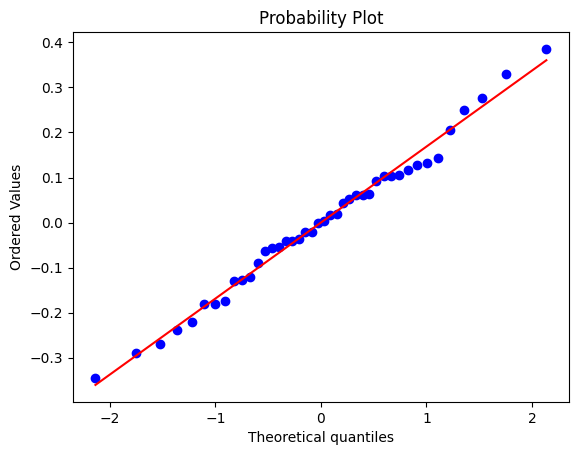

In [11]:

import scipy.stats as stats

residuals = model.resid
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

In [27]:
predicted_log_attendance = model.predict(df_model)
predicted_attendance = np.exp(predicted_log_attendance)


mape = mean_absolute_percentage_error(df_model['total_attendance'], predicted_attendance)

print('mean_absolute_percentage_error for Log-Log model:',mape)
# Create a DataFrame to store the results

percentage_diff = (abs(predicted_attendance -  df_model['total_attendance']) /  df_model['total_attendance']) * 100

percent_diff_df = pd.DataFrame({'Actual Total Attendance': df_model['total_attendance'],
                           'Predicted Total Attendance': predicted_attendance,
                           'Percentage Difference': percentage_diff,
                           'Perdict log': predicted_log_attendance,
                           'log_num_days':df_model['log_num_days'],
                           'log_reach':df_model['log_reach'],
                           'log_avg_month_search':df_model['log_avg_month_search'],
                           'high_search_main':df_model['high_search_main'],
                           'high_search_small':df_model['high_search_small']})

percent_diff_df = percent_diff_df.merge(df[['total_attendance', 'projected demand','exhibition']], left_on= 'Actual Total Attendance', right_on='total_attendance' ).drop(axis = 1,columns= 'total_attendance')

percent_diff_df['Project Percentage Difference'] = (abs(percent_diff_df['Actual Total Attendance'] -  percent_diff_df['projected demand']) /  percent_diff_df['Actual Total Attendance']) * 100


percent_diff_df['model diff']  = percent_diff_df['Project Percentage Difference'] - percent_diff_df['Percentage Difference']


percent_diff_df.sort_values('model diff')

mean_absolute_percentage_error for Log-Log model: 0.12942123601455724


,Actual Total Attendance,Predicted Total Attendance,Percentage Difference,Perdict log,log_num_days,log_reach,log_avg_month_search,high_search_main,high_search_small,projected demand,exhibition,Project Percentage Difference,model diff
11,81014.0,101030.120724,24.706990,11.523174,4.521789,17.773727,8.884333,0,0,74046.420000,The Renaissance Nude,8.600464,-16.106526
10,85618.0,101808.599674,18.910275,11.530850,4.189655,14.310207,8.238008,0,0,82236.750000,"Bill Viola / Michelangelo: Life, Death, Rebirth",3.949228,-14.961048
9,173722.0,124769.140857,28.178848,11.734220,4.499810,17.887963,9.602450,0,0,150072.000000,Klimt/Schiele: Drawings from the Albertina Mus...,13.613705,-14.565144
36,170286.0,149895.909220,11.974027,11.917696,4.454347,19.814578,8.730206,1,0,170733.600000,Marina Abramovic,0.262852,-11.711175
16,117438.0,103152.950984,12.163907,11.543968,4.510860,18.381767,9.401043,0,1,123420.000000,Lucian Freud: The Self-Portraits,5.093752,-7.070155
34,166897.0,156368.645234,6.308295,11.959972,4.110874,18.839958,10.143685,1,0,165165.000000,Summer Exhibition 2023,1.037766,-5.270529
13,70045.0,74169.806748,5.888795,11.214112,4.521789,16.635529,7.950150,0,0,72717.750000,Felix Vallotton,3.815761,-2.073034
25,145969.0,131429.627812,9.960589,11.786227,4.234107,18.364191,9.803722,0,0,159662.400000,Francis Bacon,9.381033,-0.579556
12,194537.0,185751.591917,4.516060,12.132166,4.174387,18.589531,10.113627,0,0,185565.600000,Summer Exhibition 2019,4.611668,0.095607
17,41502.0,32417.084358,21.890308,10.386441,4.510860,16.987167,7.601402,0,0,51000.000000,Eco-Visionaries: Confronting a planet in a sta...,22.885644,0.995336


## Data Visulisation

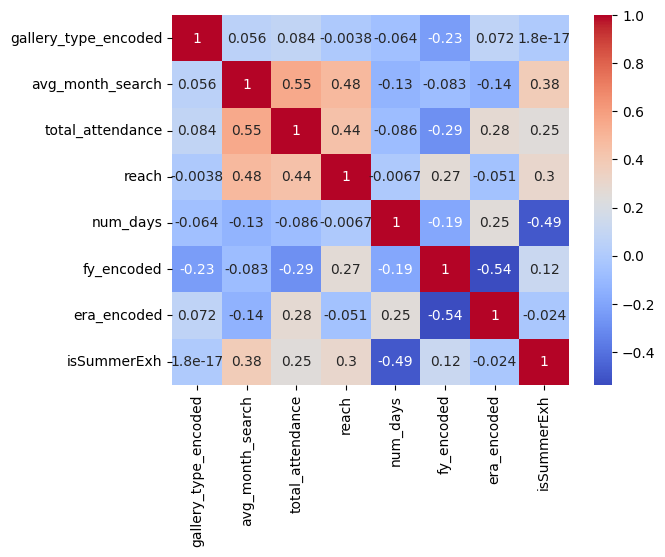

In [ ]:
# Correlation matrix

df_model  = df[ ['gallery_type_encoded','avg_month_search','total_attendance', 'reach','num_days','fy_encoded','era_encoded','isSummerExh']]


corr_matrix = df_model.corr()

# Visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

